In [1]:
# pip install -e .. -q

In [2]:
import itertools

import numpy as np
import pandas as pd
import scipy as sc
from scipy.stats import dirichlet, gamma

In [3]:
from GraphPY.posterior.plotting import plot_with_computed_post1D
from GraphPY.sampler.samplers import GPYSamplerGaussian1D

# Generating data

* Dirichlet-Multinomial approximation to GDP model
* Gaussian kernell and atom distribution
* Graph 1-2, 1-3, 2-4, 3-4
* 50 observations per node

In [4]:
# Generating the data

np.random.seed(10)

#--------------------------------------------

L = 10
alpha_0 = 10
eps = 1e-10 * np.ones(L)

sigma_phi = 3
sigma_x = 1.5

n_1 = 50
n_2 = 50
n_3 = 50
n_4 = 50

#--------------------------------------------

alpha_1 = gamma.rvs(alpha_0, 1)
alpha_2 = gamma.rvs(alpha_1, 1)
alpha_3 = gamma.rvs(alpha_1, 1)
alpha_4 = gamma.rvs(alpha_2 + alpha_3, 1)

beta_1 = dirichlet.rvs(alpha_1 * np.ones(L)/L)[0] + eps
beta_2 = dirichlet.rvs(alpha_2 * beta_1)[0] + eps
beta_3 = dirichlet.rvs(alpha_3 * beta_1)[0] + eps

pi = sc.stats.beta.rvs(alpha_2, alpha_3)

beta_4 = dirichlet.rvs(alpha_4 * (pi * beta_2 + (1 - pi) * beta_3))[0] + eps

phi = np.random.normal(loc=0, scale=sigma_phi, size=L)

#--------------------------------------------

z_1 = np.random.choice(a=np.arange(L), size=n_1, p=beta_1)
z_2 = np.random.choice(a=np.arange(L), size=n_2, p=beta_2)
z_3 = np.random.choice(a=np.arange(L), size=n_3, p=beta_3)
z_4 = np.random.choice(a=np.arange(L), size=n_4, p=beta_4)


x_1 = np.random.normal(loc=phi[z_1], scale=sigma_x)
x_2 = np.random.normal(loc=phi[z_2], scale=sigma_x)
x_3 = np.random.normal(loc=phi[z_3], scale=sigma_x)
x_4 = np.random.normal(loc=phi[z_4], scale=sigma_x)

beta_nodes = {'1': beta_1, '2': beta_2, '3': beta_3, '4': beta_4}
x = {'1': x_1, '2': x_2, '3': x_3, '4': x_4}

In [5]:
# Describing the graph

nodes = {
    '1': {
        'lvl': 0,
        'desc': ['2', '3', '4'],
        'par': [],
    },
    '2': {
        'lvl': 1,
        'desc': ['4'],
        'par': ['1'],
    },
    '3': {
        'lvl': 1,
        'desc': ['4'],
        'par': ['1'],
    },
    '4': {
        'lvl': 2,
        'desc': [],
        'par': ['2', '3'],
    },
}

In [6]:
# Evaluating the true distribution over a grid

x_min = np.min(list(itertools.chain(*x.values())))
x_max = np.max(list(itertools.chain(*x.values())))

x_min = x_min - sigma_x
x_max = x_max + sigma_x

ls = np.linspace(x_min, x_max, num=500)
f_true = dict([])

for node in nodes:

    y = [
        sum([
            beta_nodes[node][i] * sc.stats.norm.pdf(x, loc=phi[i], scale=sigma_x)
            for i in range(L)
        ])
        for x in ls
    ]
    df = pd.DataFrame({'x': ls, 'y': y})
    f_true[node] = df

# Running MCMC sampler

In [7]:
res = GPYSamplerGaussian1D(
        nodes, x,
        n_iter=100, burn_in=20, sigma=0.0,
        group_init_mode="diffuse",
        progress=True,
    )

Processing: 100%|███████████████████████████| 100/100 [00:20<00:00,  4.84iter/s]


In [9]:
posterior = plot_with_computed_post1D(nodes, x, res, f_true, grid_mode=True, figsize=(900, 900));

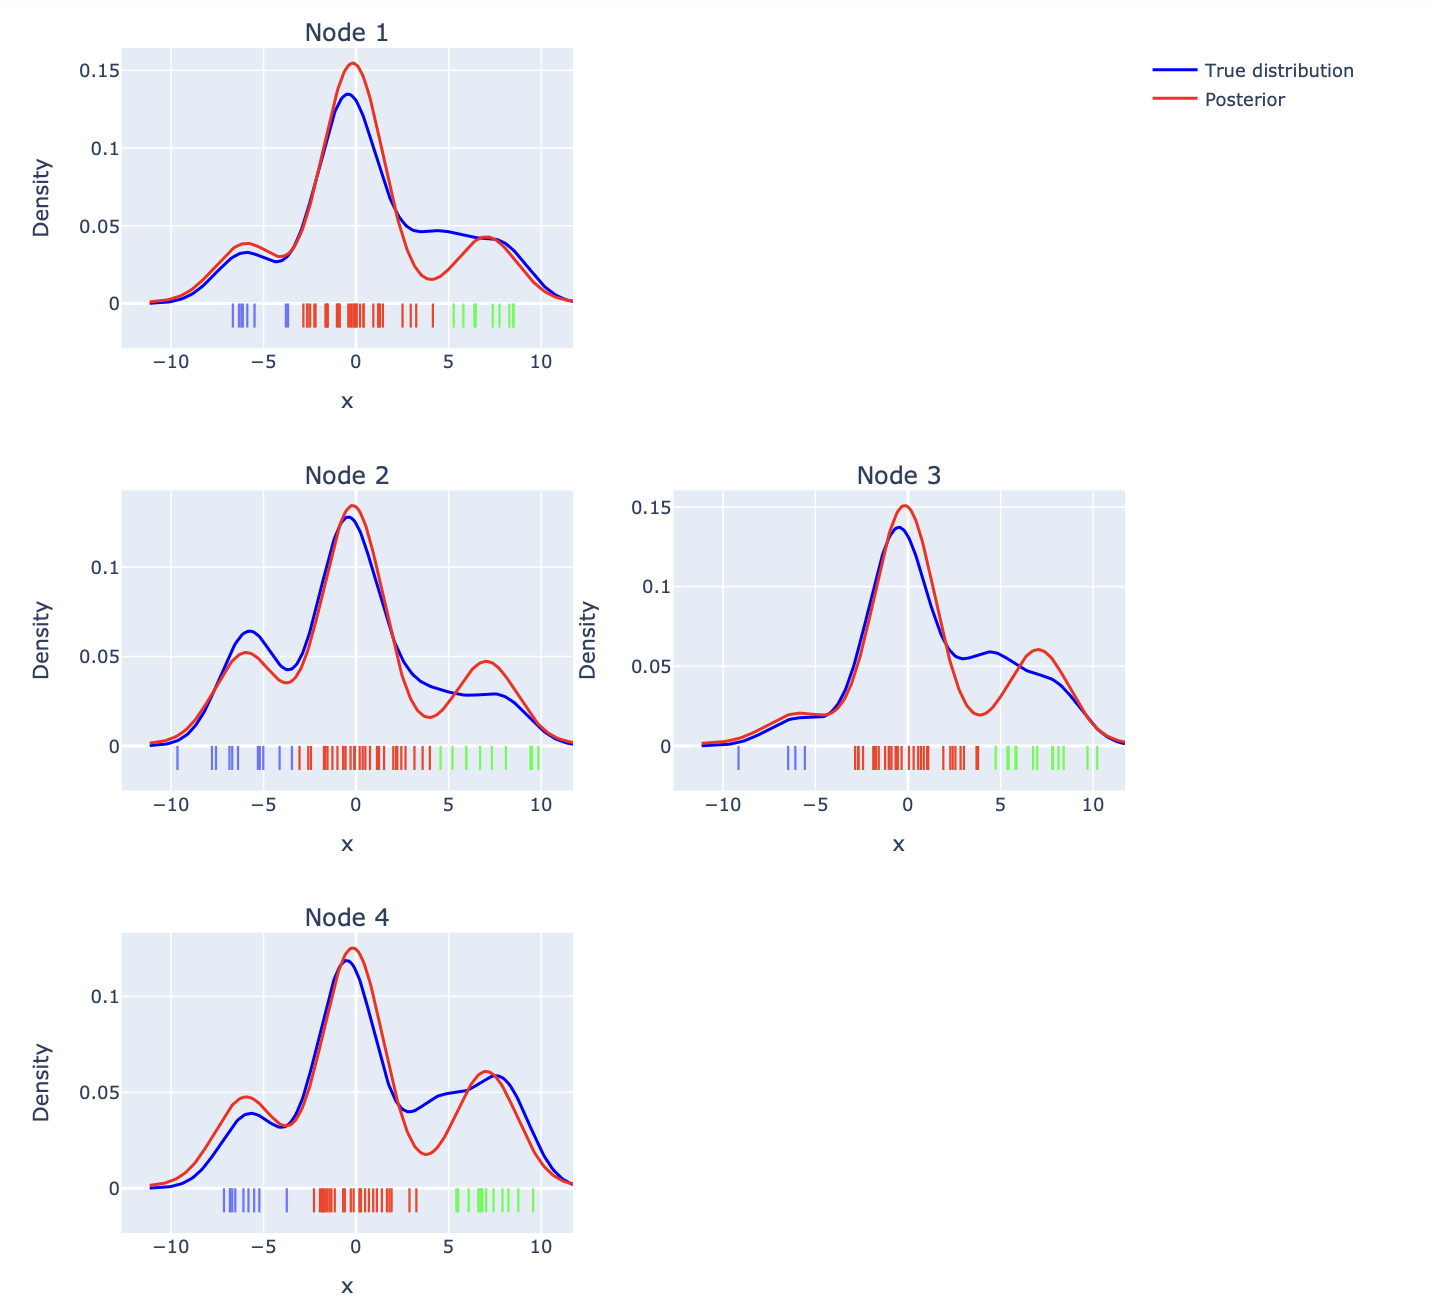